# Багатокласова класифікація

Ви будете використовувати набір даних MNIST мови жестів [Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist), який містить 28x28 зображень рук, що зображують 26* літер англійського алфавіту ().

Вам потрібно буде попередньо обробити дані, щоб їх можна було ввести у вашу згорткову нейронну мережу для правильної класифікації кожного зображення як літери, яку воно представляє..


**UPD: В наборі насправді 24 літери (нема "J", "Z"), але у вихідному шарі повинно бути 25 нейронів 🤷‍♀️.*




In [ ]:
import csv
import string
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

Завантажте навчальний та тестовий набори (тестовий набір фактично буде використано як валідаційний набір):

In [ ]:
# sign_mnist_train.csv
!gdown 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg

Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 189MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 66.0MB/s]


Визначте деякі глобальні переменні зі шляхом до обох файлів, які ви щойно завантажили:


In [ ]:
TRAINING_FILE = './sign_mnist_train.csv'
VALIDATION_FILE = './sign_mnist_test.csv'

Дані в цьому наборі подано в csv файлі

Застосуйте модуль pandas для дослідження наборів  даних

In [ ]:
data = pd.read_csv('/content/sign_mnist_train.csv')
data.head(5).iloc[:, :12]

**Очикуваний результат**

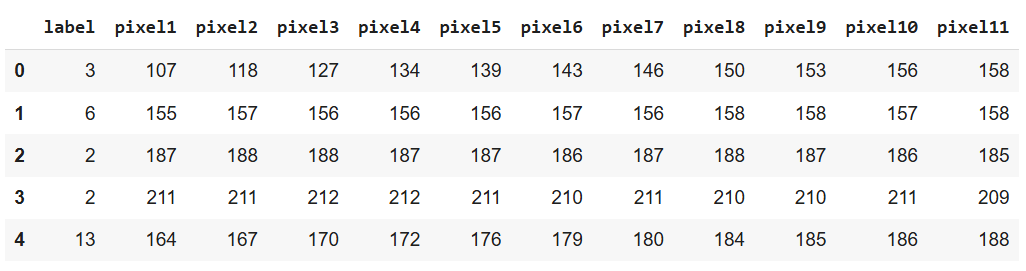

Як бачите, кожен файл містить заголовок (перший рядок), а кожна наступна точка даних представлена ​​рядком, що містить 785 значень.

Перше значення – це мітка (числове представлення кожної літери), а інші 784 значення – це значення кожного пікселя зображення. Пам’ятайте, що оригінальні зображення мають роздільну здатність 28x28, що в сумі становить 784 пікселі.

 ## Парсинг набору даних

Тепер виконайте команду `parse_data_from_input` нижче.

Ця функція повинна мати змогу зчитувати файл, переданий на вхід, та повертати 2 масиви numpy, один з яких містить мітки, а інший — представлення 28x28 кожного зображення у файлі. Ці масиви numpy повинні мати тип `float64`.

Кілька речей, які слід пам'ятати:

- Перший рядок містить заголовки стовпців, тому його слід ігнорувати.

- Кожен наступний рядок містить 785 значень, розділених комами, від 0 до 255
- Перше значення — це мітка
- Решта — це значення пікселів для цього зображення



In [ ]:

import pandas as pd

# GRADED FUNCTION: parse_data_from_input
def parse_data_from_input(filename):
  """
  Parses the images and labels from a CSV file

  Args:
    filename (string): path to the CSV file

  Returns:
    images, labels: tuple of numpy arrays containing the images and labels
  """
 ### START CODE HERE
  # Read CSV file using pandas
  data = pd.read_csv(filename, skiprows=1)
  
  # Extract labels (first column)
  labels = data.iloc[:, 0].values.astype('float64')
  
  # Extract images (remaining 784 columns, reshape to 28x28)
  images = data.iloc[:, 1:].values.astype('float64')
  images = images.reshape(-1, 28, 28)
  
  # Convert to numpy array with float64 dtype
  images = np.array(images, dtype='float64')
    ### END CODE HERE

  return images, labels

In [ ]:
# Test your function
training_images, training_labels = parse_data_from_input(TRAINING_FILE)
validation_images, validation_labels = parse_data_from_input(VALIDATION_FILE)

print(f"Training images has shape: {training_images.shape} and dtype: {training_images.dtype}")
print(f"Training labels has shape: {training_labels.shape} and dtype: {training_labels.dtype}")
print(f"Validation images has shape: {validation_images.shape} and dtype: {validation_images.dtype}")
print(f"Validation labels has shape: {validation_labels.shape} and dtype: {validation_labels.dtype}")

Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64


**Очикуваний результат**
```
Training images has shape: (27455, 28, 28) and dtype: float64
Training labels has shape: (27455,) and dtype: float64
Validation images has shape: (7172, 28, 28) and dtype: float64
Validation labels has shape: (7172,) and dtype: float64
```

## Візуалізація масивів numpy

Тепер, коли ви конвертували початкові дані csv у формат, сумісний із завданнями комп'ютерного зору, відтворіть зображення набору даних:

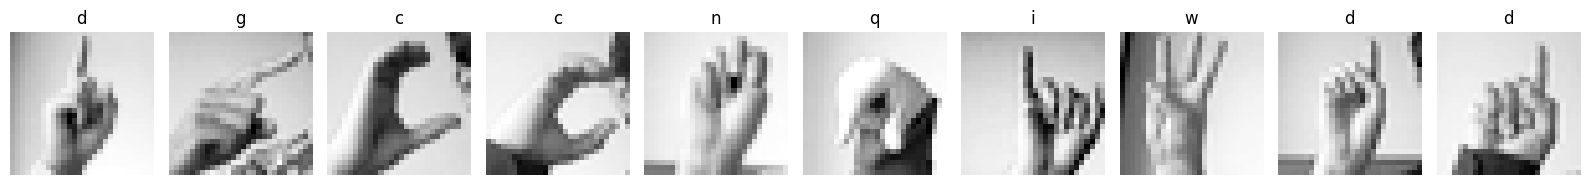

In [ ]:
# Plot a sample of 10 images from the training set
def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = list(string.ascii_lowercase)

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(training_images, training_labels)

**Очикуваний результат**

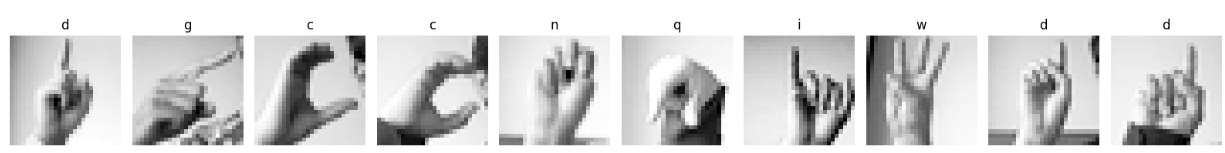

## Створення генераторів для CNN

Передайте опрацьовані дані в ImageDataGenerator від Keras для генерації батчів зображень для навчання та валідації. Для цього виконайте функцію train_val_generators.

Деякі важливі примітки:

* Зображення в цьому наборі даних мають однакову роздільну здатність, тому вам не потрібно встановлювати власний `target_size` у цьому випадку.

* Вам потрібно додати вимір "color" до масивів numpy, які кодують зображення. Це чорно-білі зображення, тому цей новий вимір повинен мати розмір 1 (замість 3, який використовується під час роботи з кольоровими зображеннями). Зверніть увагу на функцію `np.expand_dims` або ж атрибут `np.newaxis` для цього.

In [ ]:
def train_val_generators(training_images, training_labels, validation_images, validation_labels):
  """
  Creates the training and validation data generators

  Args:
    training_images (array): parsed images from the train CSV file
    training_labels (array): parsed labels from the train CSV file
    validation_images (array): parsed images from the test CSV file
    validation_labels (array): parsed labels from the test CSV file

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # In this section you will have to add another dimension to the data
  # So, for example, if your array is (10000, 28, 28)
  # You will need to make it (10000, 28, 28, 1)

  training_images = np.expand_dims(training_images, axis=-1)
  validation_images = np.expand_dims(validation_images, axis=-1)

  # Instantiate the ImageDataGenerator class
  # Don't forget to normalize pixel values
  # and set arguments to augment the images (if desired)
  train_datagen = ImageDataGenerator(
      rescale=1.0/255.0,
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      zoom_range=0.1
  )


  # Pass in the appropriate arguments to the flow method
  train_generator = train_datagen.flow(
      training_images,
      training_labels,
      batch_size=32
  )


  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(
      rescale=1.0/255.0
  )

  # Pass in the appropriate arguments to the flow method
  validation_generator = validation_datagen.flow(
      validation_images,
      validation_labels,
      batch_size=32
  )

  ### END CODE HERE

  return train_generator, validation_generator

In [ ]:
# Test your generators
train_generator, validation_generator = train_val_generators(training_images, training_labels, validation_images, validation_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {validation_generator.x.shape}")
print(f"Labels of validation generator have shape: {validation_generator.y.shape}")

**Очикуваний результат**
```
Images of training generator have shape: (27455, 28, 28, 1)
Labels of training generator have shape: (27455,)
Images of validation generator have shape: (7172, 28, 28, 1)
Labels of validation generator have shape: (7172,)
```

## Кодування CNN
Останній крок перед навчанням – визначення архітектури моделі, яка буде навчатися.

Виконайте функцію create_model нижче. Ця функція повинна повернути модель Keras, яка використовує послідовний або функціональний API.

Останній шар вашої моделі повинен мати кількість ,юнітів, що відповідає кількості можливих категорій, а також правильну функцію активації.

Окрім визначення архітектури моделі, її також слід скомпілювати, тому переконайтеся, що ви використовуєте функцію втрат, яка підходить для багатокласової класифікації.

Зверніть увагу, що для досягнення бажаної продуктивності слід використовувати не більше 2 шарів Conv2D та 2 шарів MaxPooling2D.

In [ ]:
# grader-required-cell

def create_model():

  ### START CODE HERE

  # Define the model
  # Use no more than 2 Conv2D and 2 MaxPooling2D
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(25, activation='softmax')
  ])

#   Pass in the appropriate arguments
  model.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

  ### END CODE HERE

  return model

In [ ]:
# Save your model
model = create_model()

# Train your model

# Pass in the appropriate arguments
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator)
)

Перегляньте свою історію тренувань

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Приблизний результат**


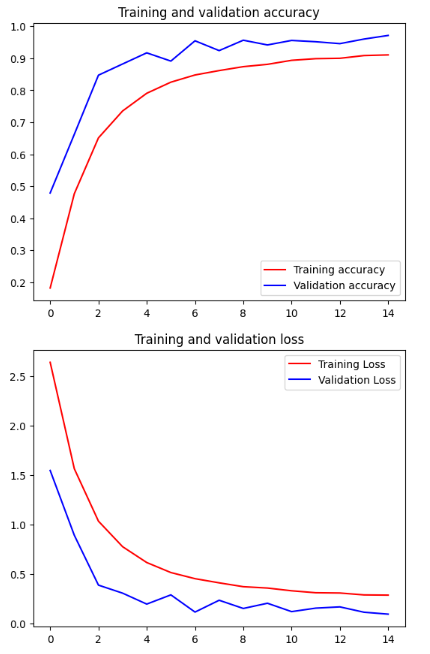

Доцільним орієнтиром є досягнення точності понад 99% для навчання та понад 95% точності для валідації протягом 15 епох.

Спробуйте налаштувати архітектуру вашої моделі або методи аугменатації, щоб побачити, чи можете ви досягти цих рівнів точності.

Побудуйте матрицю втрат (confusion matrix) для тестового набору даних

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ENTER CODE HERE
# Get predictions on validation data
validation_predictions = model.predict(validation_generator)
validation_pred_labels = np.argmax(validation_predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(validation_labels, validation_pred_labels)

# Pass in the appropriate arguments
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
### END CODE HERE